Link to Github repository: https://github.com/fridamariejoergensen/CSS.git <br>
### Contribution Statement

We, Frida(s206182), Cecilie(s214605), and Marie(sXXXXXX), collaborated on Assignment 1 in Jupyter Notebook and made the following contributions:

- Cecilie focused on this

- Frida did this

- Marie did this



# Assignment 1

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt


## Part 1: Using web-scraping to gather data

### 2019 edition

In [ ]:
## Poster
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content)

In [ ]:
listul = soup.find("div",{"class":"col-md-8 page-content-wrap"})
listli = listul.find_all("li")

allnames = []
for i in range(len(listli)):
    if listli[i].find("strong"):
        listli[i].strong.extract()
    if listli[i].find("span"):
        listli[i].span.extract()
    if listli[i].find("br"):
        listli[i].br.extract()
        
    names = listli[i].text.replace("\n","").replace(" and ",",").replace(", ",",")
    allnames = allnames + names.split(",")
    


un2019 = np.unique(np.array(allnames))
len(un2019)

There was ?? unique researchers that made poster presentations in 2019  

In [6]:
#### Oral
LINK = 'https://2019.ic2s2.org/oral-presentations/'
r = requests.get(LINK)
all_oral = BeautifulSoup(r.content)

In [ ]:
# extract the specific element of the site that contains the names
paragraphs = all_oral.find_all("p", {"class":""})[3:39]

In [ ]:
names = []
for p in paragraphs:
    text = p.text.strip()
    lines = text.split(' – ')
    names.extend([line.split('.')[0] for line in lines[1:]])

In [ ]:
# code that extracts list elements that contain numbers.

def remove_elements_with_numbers(names):
    return [i for i in names if not any(j.isdigit() for j in i)]

p = remove_elements_with_numbers(names)

In [2]:
newlist = [word for line in p for word in line.split(',')]
newlist.remove('No Presentation')
final_list = np.asarray(newlist)
print(len(np.unique(final_list)))

NameError: name 'p' is not defined

There was ?? unique researchers that made oral presentations in 2019  

In [5]:
# Combine the two lists of poster and oral presentators
combined_list = np.concatenate((final_list, un2019))
# Find the length of unique combined list that attended the conference in 2019 
print(len(np.unique(combined_list)))

NameError: name 'np' is not defined

In total there was ?? unique researchers you got in 2019

Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

## Part 2: Getting data from the Semantic Scholar API
Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find: <br>
- their aliases <br>
- their name <br>
- their papers <br>

(**Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not!!)

Create three dataframe to store the data you have collected:

**Author dataset**: in the author dataset, one raw is one unique author, and each row contains the following information: <br>
- authorId: (str) the id of the author <br>
- name: (str) the name of the author <br> 
- aliases: (list) the aliases of the author <br>
- citationCount: (int) the total number of citations received by an author <br>
- field: (str) the s2FieldsOfStudy that occurs most times across an author's papers (you should first obtain the category for each s2FieldsOfStudy) 



**Paper dataset**: in the paper dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- title: (str) the title of the paper <br> 
- year: (int) the year of publication <br>
- externalId.DOI: (str) the DOI of the paper <br>
- citationCount: (int) the number of citations <br>
- fields: (list) the fields included in the paper (you should first obtain the category for each s2FieldsOfStudy) <br>
-  authorIds: (list) this is a list of author Ids, including all the authors of this paper that are in our author dataset



**Paper abstract dataset**: in the paper abstract dataset, one row is one unique paper, and each row contains the following information: <br>
- paperId: (str) the id of the paper <br>
- abstract: (str) the abstract of the paper


How long is your final Author dataframe? How long is your final Paper dataframe?

## Part 3: Law of large numbers.

In [4]:
# 1. Sampling 10.000 points from Gaussian distribution with mean 0 and std 4
N = 10000
mu = 0
sigma = 4

X = np.random.normal(mu, sigma, N)

-17.49355546826846 13.74973390775722


<BarContainer object of 49 artists>

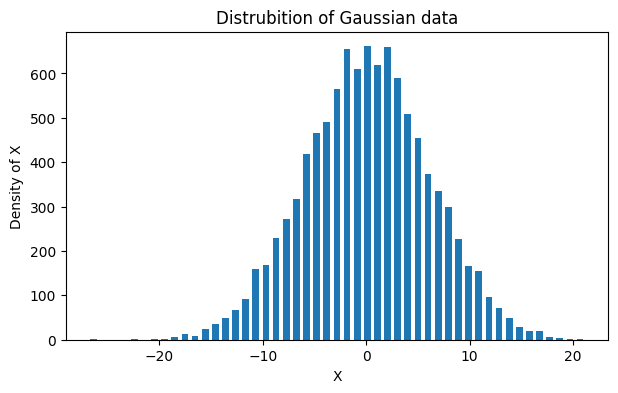

In [31]:
# 2. Plotting the distribution of Gaussian data in a histogram
print(min(X), max(X)) # min(X) = -17.5, max(X) = 14

bins = np.linspace(-18, 14, 50)
hist, edges = np.histogram(X, bins=bins)
x = edges[1:]+edges[:-1]/2
width = bins[1]-bins[0]
fig, ax = plt.subplots(figsize=(7,4))
ax.set_ylabel('Density of X')
ax.set_xlabel('X')
ax.set_title('Distrubition of Gaussian data')
ax.bar(x, hist, width)

In [16]:
# 3. Cumulative average of X
cum_av = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_av = np.append(cum_av, np.mean(val))
    
print(cum_av)

[ 1.90828286 -0.10988178 -1.02379411 ... -0.04193847 -0.04181708
 -0.04232607]


In [17]:
# 4. Cumulative std of X
cum_std = np.array([])
for i in range(1, N+1):
    val = X[0:i]
    cum_std = np.append(cum_std, np.std(val)/np.sqrt(N))
    
print(cum_std)

[0.         0.02018165 0.02094229 ... 0.04020488 0.04020306 0.04020427]


In [24]:
# 5. Computing the distribution mean and median from Wikipedia formulas
mean = 1/N * sum(X)

X_new = np.copy(X) # making a copy of array to sort in order to calculate the median
X_new = np.sort(X_new)
median = (X_new[int(N/2)] + X_new[int((N/2+1))])/2

print(mean, median)

-0.04232606886363468 -0.014551698218535223


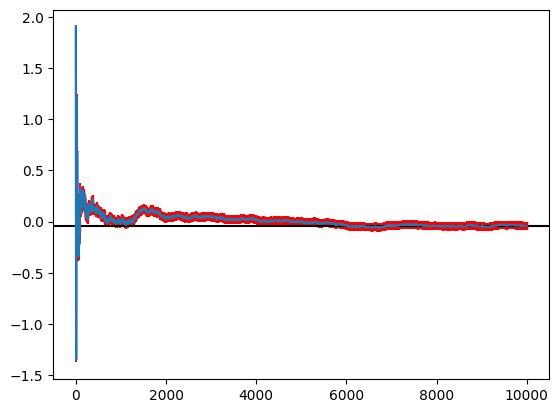

In [35]:
# 6. Plot of cumulative average as line plot with error bars and horizontal line of distribution mean
plt.plot(range(N), cum_av, c = 'blue') # cumulative average is blue
plt.errorbar(range(N), cum_av, yerr = cum_std, ecolor='red') # error bars are red
plt.axhline(mean, c = 'black') # distribution mean is black
#plt.xticks(np.arange(-100,10000,step=5))